In [2]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=2625fd8a5d4baa3d0e04dba013b616ea594ec778b688184274f552177fb1a15e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=b0a2d354a73eaae487687638196c954c3d9a57070db60e8b9544897d6b1f6349
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


Printing top 5 rows of dataframe showing original and cleaned tweets....
                                                                                                             Review  \
0  Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.   
1                            Please ignore previous negative rating. This app is super great. I give it five stars+   
2                                                                   Really buggy and terrible to use as of recently   
3              Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?   
4                               I love the selection and the lyrics are provided with the song you're listening to!   

                                                                                  cleaned_Review  
0  [great, music, service, audio, high, quality, app, easy, use, also, quick, friendly, support]  
1             

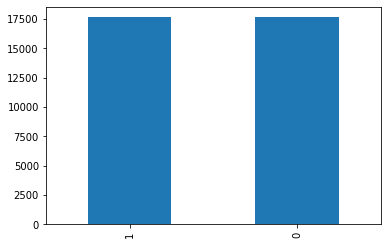

In [4]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.svm import LinearSVC
import joblib
import umap
import plotly.graph_objs as go
import plotly.figure_factory as ff


#PART 1 
#SUPERVISED DATA MINING

# Reading dataset as dataframe
df = pd.read_csv("SpotifyReviews.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window
df['Recommend'] = df['Recommend'].map({'Yes':1, 'No':0})
pd.value_counts(df['Recommend']).plot.bar()#visualizing value count of taget column to see whether it is is balanced or not.



# Cleaning Tweets
def cleaner(Review):
    soup = BeautifulSoup(Review, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

df['cleaned_Review'] = df.Review.apply(cleaner)
df = df[df['cleaned_Review'].map(len) > 0] # removing rows with cleaned tweets of length 0
print("Printing top 5 rows of dataframe showing original and cleaned tweets....")
print(df[['Review','cleaned_Review']].head())
df.drop(['Review'], axis=1, inplace=True)
# Saving cleaned tweets to csv
df.to_csv('cleaned_data.csv', index=False)
df['cleaned_Review'] = [" ".join(row) for row in df['cleaned_Review'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_Review']

Y = df['Recommend'] # target column
tfidf = TfidfVectorizer(min_df=.0086, ngram_range=(1,3)) # min_df=.0086 means that each ngram (unigram, bigram, & trigram) must be present in at least 303 documents for it to be considered as a token (35295*.0086=303). This is a clever way of feature engineering
tfidf.fit(data) # learn vocabulary of entire data
data_tfidf = tfidf.transform(data) # creating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('/content/drive/MyDrive/Colab Notebooks/vocabulary_reviews.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)

# Implementing Support Vector Classifier
model = LinearSVC() #kernel = 'linear' and C = 1

# Running cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
smote = SMOTE(random_state=42)
scores=[]
iteration = 0
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    X_train, Y_train = data_tfidf[train_index], Y.iloc[train_index]
    X_train, Y_train = smote.fit_resample(X_train, Y_train)#Balancing the Training Data
    X_test, Y_test = data_tfidf[test_index], Y.iloc[test_index]
    model.fit(X_train, Y_train) # Fitting SVC
    Y_pred = model.predict(X_test)
    score = metrics.precision_score(Y_test, Y_pred) # Calculating accuracy
    print("Cross-validation accuracy: ", score)
    scores.append(score) # appending cross-validation accuracy for each iteration
svc_mean_accuracy = np.mean(scores)
print("Mean cross-validation accuracy: ", svc_mean_accuracy)

# Implementing Naive Bayes Classifier
NBModel = MultinomialNB()

# Running cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
smote = SMOTE(random_state=10)

scores=[]
iteration = 0
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    X_train, Y_train = data_tfidf[train_index], Y.iloc[train_index]
    X_train, Y_train = smote.fit_resample(X_train, Y_train)#Balancing the Training Data
    X_test, Y_test = data_tfidf[test_index], Y.iloc[test_index]
    NBModel.fit(X_train, Y_train) # Fitting NBC
    Y_pred = NBModel.predict(X_test)
    score = metrics.precision_score(Y_test, Y_pred) # Calculating accuracy
    print("Cross-validation accuracy: ", score)
    scores.append(score) # appending cross-validation accuracy for each iteration
nbc_mean_accuracy = np.mean(scores)
print("Mean cross-validation accuracy: ", nbc_mean_accuracy)

# Creating SVC on entire data and saving it
if svc_mean_accuracy > nbc_mean_accuracy:
  clf_Linear = LinearSVC().fit(data_tfidf, Y)
  joblib.dump(clf_Linear, '/content/drive/MyDrive/Colab Notebooks/svc_new.sav')
else:
  clf_NB = MultinomialNB().fit(data_tfidf, Y)
  joblib.dump(clf_NB, '/content/drive/MyDrive/Colab Notebooks/nbc_new.sav')





In [5]:
#Part 1 
#TestReviews
#Model Deployment
model_new = joblib.load('/content/drive/MyDrive/Colab Notebooks/svc_new.sav')#loading the Model which was saved previosly as it was considered better
vocabulary = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vocabulary_reviews.csv', header=None)
vocabulary_dict = {}
for i, word in enumerate(vocabulary[0]):
      vocabulary_dict[word] = i
print(vocabulary_dict)
tfidf_2 = TfidfVectorizer(vocabulary = vocabulary_dict,lowercase=False)

# Reading new data as dataframe
df_2 = pd.read_csv("TestReviews.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window

# Cleaning Tweets
def cleaner(Review):
    soup = BeautifulSoup(Review, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

df_2['cleaned_Review_2'] = df_2.Review.apply(cleaner)
df_2 = df_2[df_2['cleaned_Review_2'].map(len) > 0] # removing rows with cleaned tweets of length 0
print("Printing top 5 rows of dataframe showing original and cleaned tweets....")
print(df_2[['Review','cleaned_Review_2']].head())
df_2['cleaned_Review_2'] = [" ".join(row) for row in df_2['cleaned_Review_2'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df_2['cleaned_Review_2']
print(df_2['cleaned_Review_2'].head())
tfidf_2.fit(data)
data_tfidf_2 = tfidf_2.transform(data)
y_pred = model_new.predict(data_tfidf_2)
df_2['predicted_recommendations'] = y_pred.reshape(-1,1)
df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_recommendations', index=False)

{'able': 0, 'absolutely': 1, 'access': 2, 'account': 3, 'actually': 4, 'ad': 5, 'add': 6, 'ago': 7, 'album': 8, 'almost': 9, 'already': 10, 'also': 11, 'always': 12, 'amazing': 13, 'android': 14, 'annoying': 15, 'another': 16, 'anymore': 17, 'anything': 18, 'app': 19, 'app ever': 20, 'app listen': 21, 'app music': 22, 'application': 23, 'apps': 24, 'artist': 25, 'audio': 26, 'available': 27, 'awesome': 28, 'back': 29, 'bad': 30, 'bar': 31, 'best': 32, 'best app': 33, 'best music': 34, 'best music app': 35, 'better': 36, 'bluetooth': 37, 'bug': 38, 'buggy': 39, 'button': 40, 'buy': 41, 'cancel': 42, 'cant': 43, 'car': 44, 'change': 45, 'choice': 46, 'choose': 47, 'click': 48, 'close': 49, 'come': 50, 'completely': 51, 'connect': 52, 'connection': 53, 'constantly': 54, 'control': 55, 'could': 56, 'crash': 57, 'crashing': 58, 'customer': 59, 'data': 60, 'day': 61, 'device': 62, 'different': 63, 'dont': 64, 'download': 65, 'downloaded': 66, 'easy': 67, 'easy use': 68, 'else': 69, 'email': 

In [ ]:
#PART 2 #Unsupervised Data Mining

In [6]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.svm import LinearSVC
import joblib
import umap
import plotly.graph_objs as go
import plotly.figure_factory as ff


#PART 2 
#UNSUPERVISED DATA MINING
#UMAP Visualization

# Reading dataset as dataframe
df = pd.read_csv("SpotifyReviews.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window
df['Recommend'] = df['Recommend'].map({'Yes':1, 'No':0})




# Cleaning Tweets
def cleaner(Review):
    soup = BeautifulSoup(Review, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

df['cleaned_Review'] = df.Review.apply(cleaner)
df = df[df['cleaned_Review'].map(len) > 0] # removing rows with cleaned tweets of length 0
print("Printing top 5 rows of dataframe showing original and cleaned tweets....")
print(df[['Review','cleaned_Review']].head())
# Saving cleaned tweets to csv
df.to_csv('cleaned_data.csv', index=False)
df['cleaned_Review'] = [" ".join(row) for row in df['cleaned_Review'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_Review']

Y = df['Recommend'] # target column
tfidf = TfidfVectorizer(min_df=.0086, ngram_range=(1,3))  # min_df=.0086 means that each ngram (unigram, bigram, & trigram) must be present in at least 303 documents for it to be considered as a token (35295*.0086=303). This is a clever way of feature engineering
tfidf.fit(data) # learn vocabulary of entire data
data_tfidf = tfidf.transform(data) # creating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('/content/drive/MyDrive/Colab Notebooks/vocabulary_reviews.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)

# Implementing UMAP to visualize dataset
u = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.4)
x_umap = u.fit_transform(data_tfidf)

recommend = list(df['Recommend'])
review = list(df['Review'])

data_ = [go.Scatter(x=x_umap[:,0], y=x_umap[:,1], mode='markers',
                    marker = dict(color=df['Recommend'], colorscale='Rainbow', opacity=0.5),
                                text=[f'Recommend: {a}<br>Review: {b}' for a,b in list(zip(recommend, review))],
                                hoverinfo='text')]

layout = go.Layout(title = 'UMAP Dimensionality Reduction', width = 1500, height = 800,
                    xaxis = dict(title='First Dimension'),
                    yaxis = dict(title='Second Dimension'))
fig = go.Figure(data=data_, layout=layout)
fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Printing top 5 rows of dataframe showing original and cleaned tweets....
                                                                                                             Review  \
0  Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.   
1                            Please ignore previous negative rating. This app is super great. I give it five stars+   
2                                                                   Really buggy and terrible to use as of recently   
3              Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?   
4                               I love the selection and the lyrics are provided with the song you're listening to!   

                                                                                  cleaned_Review  
0  [great, music, service, audio, high, quality, app, easy, use, also, quick, friendly, support]  
1             